In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

In [2]:
df = pd.read_excel('Data/YS_DP.xlsx')
# orgainize data by setting ID as the index
df.sort_values(by = 'ID', inplace = True)
df.set_index(keys = 'ID', inplace = True)
# truncate datetime to year and month
df['Date_month'] = df.DT.dt.year.astype('str') + '-' + df.DT.dt.month.astype('str')
df['Date_month'] = pd.to_datetime(df['Date_month'])
# select columns containing useful data and rename columns 
df = df[['INSTR_NO', 'Date_month', 'V11', 'V12', 'R11']]
df.rename(columns = {'V11' : 'Displace_iron',
                    'V12' : 'Displace_Al',
                    'R11' : 'Deformation'},
         inplace =  True)
features = ['Displace_iron', 'Displace_Al', 'Deformation']
# fill missing values 
values = {feature : df[feature].median() for feature in features}
df.fillna(value = values, inplace = True)

In [3]:
# Prepare dataset to separate into different sensors 
sensors = df.INSTR_NO.unique()
dict_sensor = {}
for sensor in sensors:
    dict_sensor[sensor] = df[df.INSTR_NO == sensor]
for key, value in dict_sensor.items():
    dict_sensor[key] = dict_sensor[key].drop(columns = 'INSTR_NO')

In [4]:
# plot function for ploting outliers 
# columns: differnt outlier detection algorithms
# rows: different features 
def plot_outliers(dict_def, row, col):
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['font.family'] = "serif"
    fig, axes = plt.subplots(row , col, figsize = (col * 5, row * 7),
                            dpi= 80, facecolor='w', edgecolor='k')
    for (sensor, cat), ax in zip(list(itertools.product(dict_def.keys(), features)),
                                 axes.T.flat):
        df = dict_def[sensor]
        ax.scatter(df.loc[df.Outliers == 'Outliers', 'Date_month'], 
                                           df.loc[df.Outliers == 'Outliers', cat], 
                                           color = 'r', label = 'Outliers', s = 10, alpha = .5)
        ax.scatter(df.loc[df.Outliers == 'Normal', 'Date_month'], 
                                           df.loc[df.Outliers == 'Normal', cat], 
                                           color = 'g', label = 'Normal', s = 10, alpha = .5)
        ax.set_title(sensor + '-' + cat, fontsize=20)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
    
    fig.legend(labels= ['Outliers', 'Normal'],  
               loc="right",  
               borderaxespad=0.1,    
               title="Legend Title") 
    fig.tight_layout(pad=3.0)

# Isolation Forest

In [5]:
from sklearn.ensemble import IsolationForest
dict_iso = {}
for sensor, df_iso in dict_sensor.items():
    iso = IsolationForest(contamination = 0.1)
    yhat = iso.fit_predict(df_iso.drop(columns = 'Date_month'))
    dict_iso['iso_' + sensor] = df_iso.copy()
    dict_iso['iso_' + sensor]['Outliers'] = ['Outliers' if i == -1 else 'Normal' for i in yhat]

# 1.5 IQR range

In [6]:
# write algorithm for 1.5 IQR range 
# we say an observation is an outlier if two or more features are outliers 
dict_iqr = {}
for sensor, df_sen in dict_sensor.items():
    df_iqr = df_sen.copy()
    df_iqr['Outliers'] = 0
    for cat in features:
        q1, q3 = np.percentile(df_iqr[cat], [25,75])
        iqr = q3 - q1
        iqrmax, iqrmin = q3 + 1.5 * iqr, q1 - 1.5 * iqr
        ser_cat = [1 if (i > iqrmax) | (i < iqrmin) else 0 for i in df_iqr[cat]]
        df_iqr['Outliers'] += ser_cat
    map_dict = {0 : 'Normal'}
    map_dict.update({i : 'Outliers' for i in range(1, len(features) + 1)})
    df_iqr['Outliers'] = df_iqr.Outliers.map(map_dict)
    dict_iqr['iqr_' + sensor] = df_iqr

# Combination of IQR and Isolation forest

In [7]:
# find outliers by using the percent of outliers calculated by IQR and Isolation forest algorithm
from sklearn.ensemble import IsolationForest
dict_iso_iqr = {}

dict_iqr_inter = {}
for sensor, df_sen in dict_sensor.items():
    df_iqr_inter = df_sen.copy()
    df_iqr_inter['Outliers'] = 0
    for cat in features:
        q1, q3 = np.percentile(df_iqr_inter[cat], [25,75])
        iqr = q3 - q1
        iqrmax, iqrmin = q3 + 1.5 * iqr, q1 - 1.5 * iqr
        ser_cat = [1 if (i > iqrmax) | (i < iqrmin) else 0 for i in df_iqr_inter[cat]]
        df_iqr_inter['Outliers'] += ser_cat
    dict_iqr_inter['iqr_' + sensor] = df_iqr_inter
    
for sensor, df_sen in dict_sensor.items():
    iso = IsolationForest(
        contamination= dict_iqr_inter['iqr_' + sensor].Outliers.mean())
    yhat = iso.fit_predict(df_sen.drop(columns = 'Date_month'))
    dict_iso_iqr['iso_iqr_' + sensor] = df_sen.copy()
    dict_iso_iqr['iso_iqr_' + sensor]['Outliers'] = ['Outliers' if i == -1 else 'Normal' for i in yhat]

# LocalOutlierFactor (knn)

In [8]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=17)
dict_knn = {}
for sensor, df_knn in dict_sensor.items():
    yhat = clf.fit_predict(df_knn.drop(columns = 'Date_month'))
    dict_knn['knn_' + sensor] = df_knn.copy()
    dict_knn['knn_' + sensor]['Outliers'] = ['Outliers' if i == -1 else 'Normal' for i in yhat]

In [9]:
dict_std = {}
for sensor, df_sen in dict_sensor.items():
    df_std = df_sen.copy()
    df_std['Outliers'] = 0
    for cat in features:
        mean, std = df_std[cat].mean(), df_std[cat].std()
        stdmax, stdmin = mean + 3 * std, mean - 3 * std
        df_std['Outliers' + '_' + cat] = [1 if (i > stdmax) | (i < stdmin) else 0 for i in df_std[cat]]
        ser_cat = [1 if (i > stdmax) | (i < stdmin) else 0 for i in df_std[cat]]
        df_std['Outliers'] += ser_cat
    map_dict = {0 : 'Normal'}
    map_dict.update({i : 'Outliers' for i in range(1, len(features) + 1)})
    df_std['Outliers'] = df_std.Outliers.map(map_dict)
    dict_std['std_' + sensor] = df_std

# Wrap up! 

In [10]:
# combine dataframes into one dictionary
dict_compare = {}
dict_compare.update(dict_iso)
dict_compare.update(dict_iqr)
dict_compare.update(dict_iso_iqr)
dict_compare.update(dict_knn)
dict_compare.update(dict_std)
# separate dictionary into different sensors 
dict_DS01 = {key : dict_compare[key] for key in ['iso_DS01', 'iqr_DS01', 'iso_iqr_DS01', 'knn_DS01', 'std_DS01']}
dict_DS02 = {key : dict_compare[key] for key in ['iso_DS02', 'iqr_DS02', 'iso_iqr_DS02', 'knn_DS02', 'std_DS02']}
dict_DS03 = {key : dict_compare[key] for key in ['iso_DS03', 'iqr_DS03', 'iso_iqr_DS03', 'knn_DS03', 'std_DS03']}
dict_DS04 = {key : dict_compare[key] for key in ['iso_DS04', 'iqr_DS04', 'iso_iqr_DS04', 'knn_DS04', 'std_DS04']}

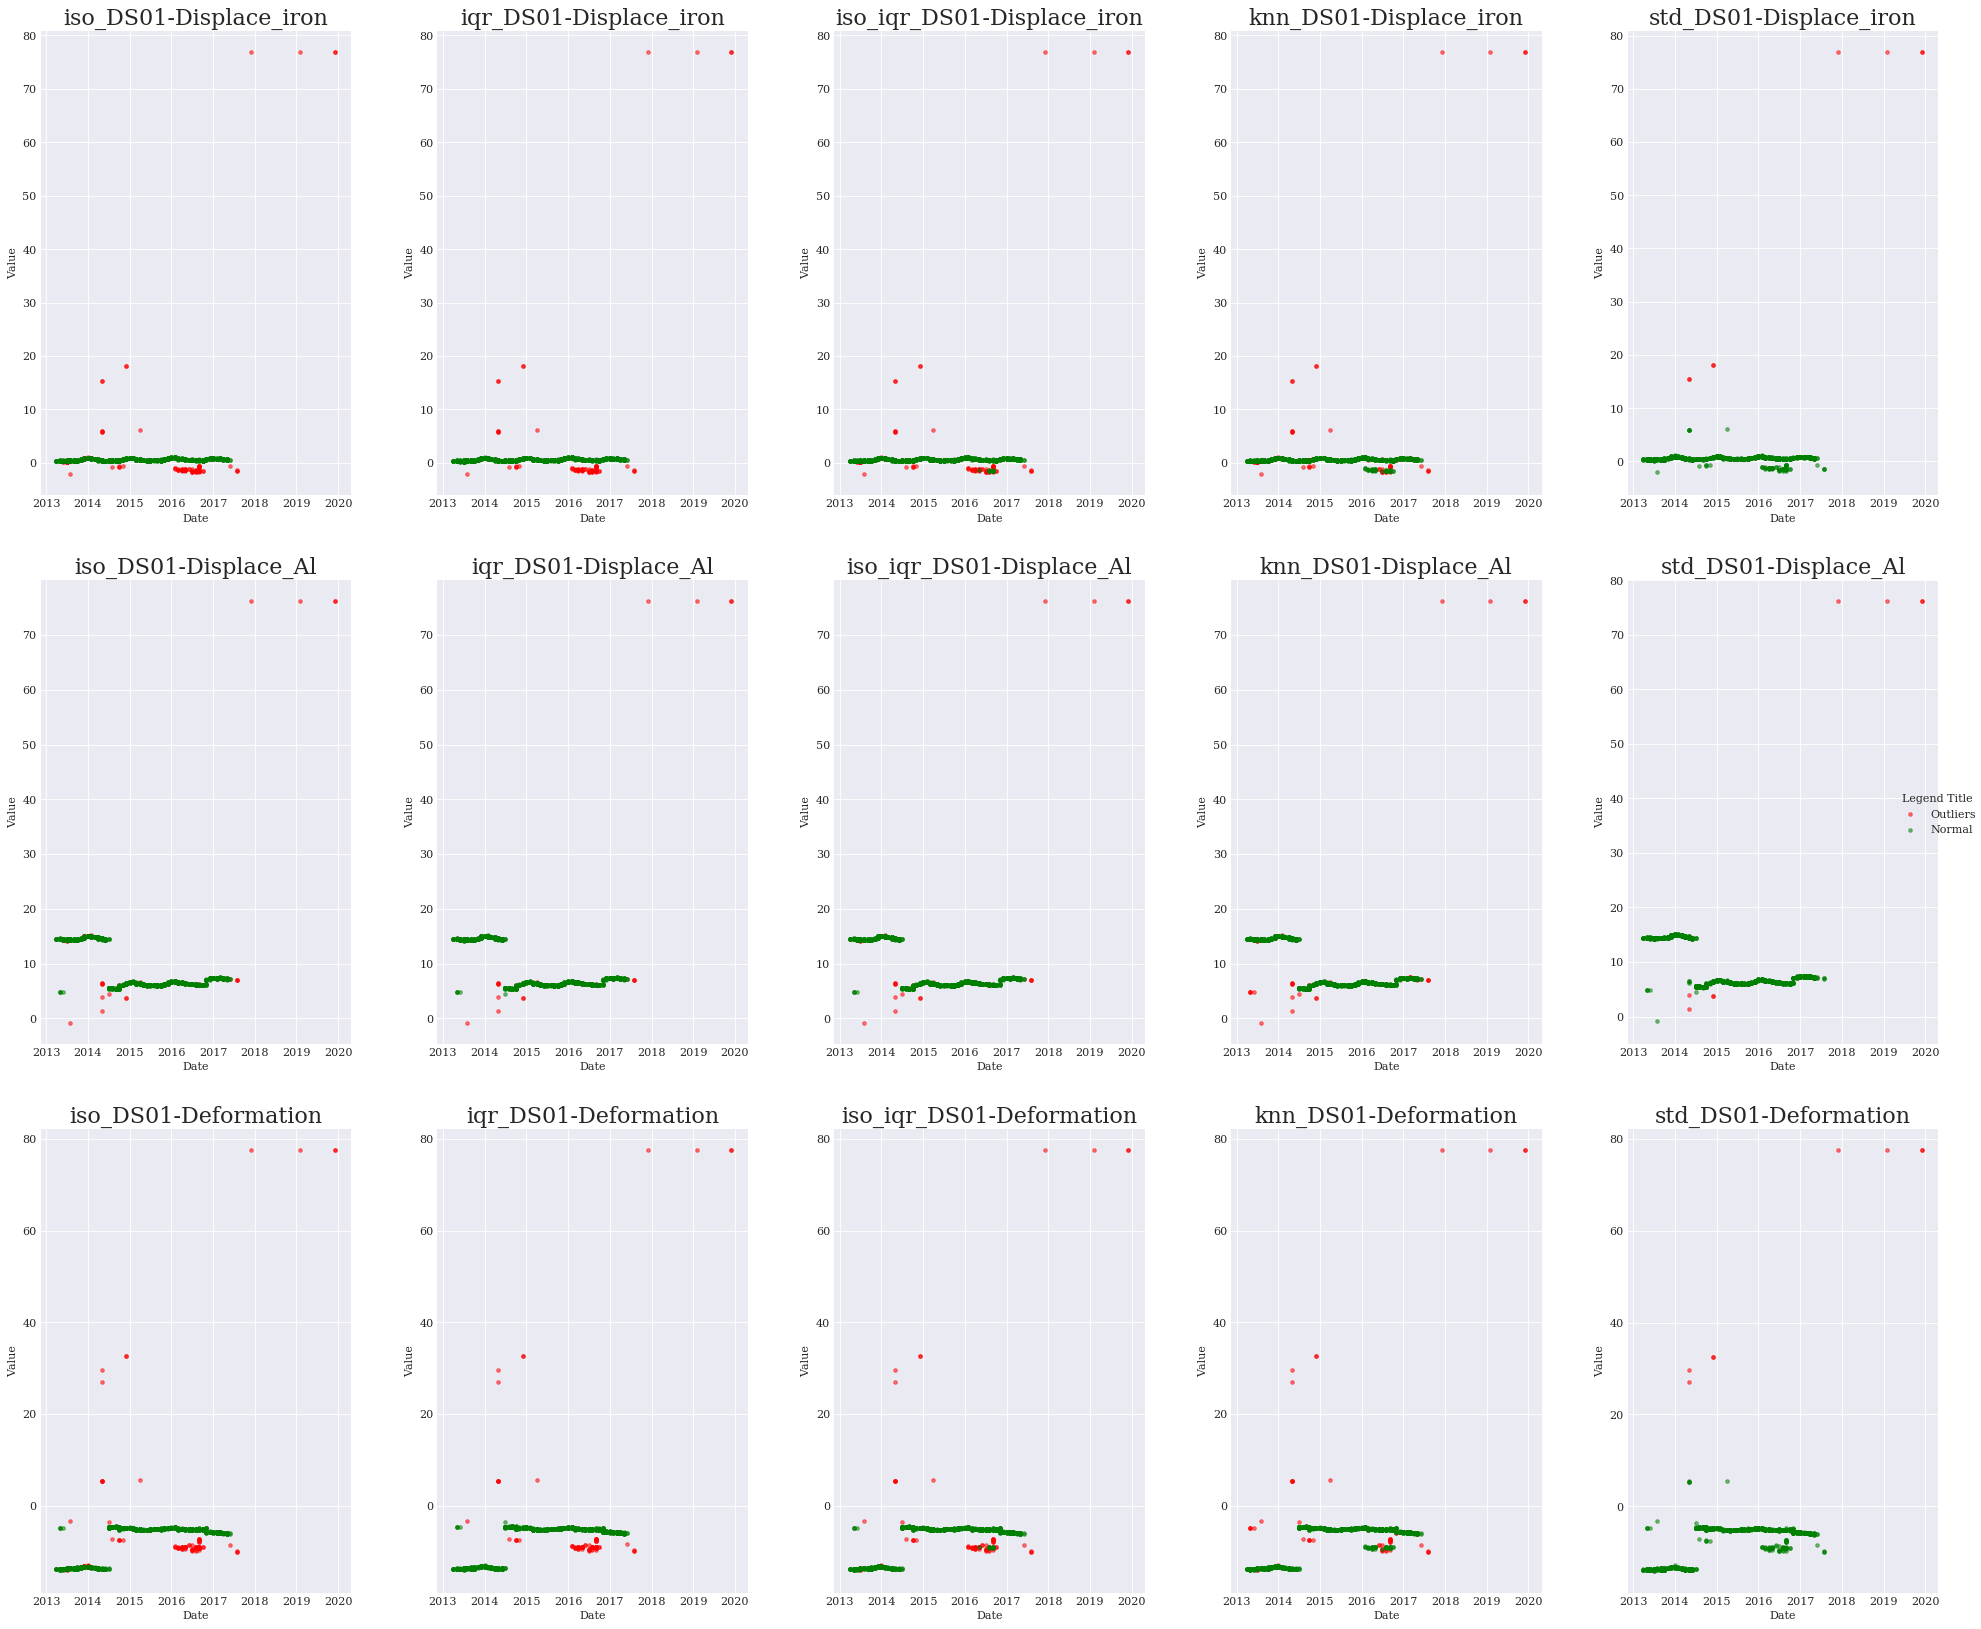

In [11]:
plot_outliers(dict_DS01, 3, 5)


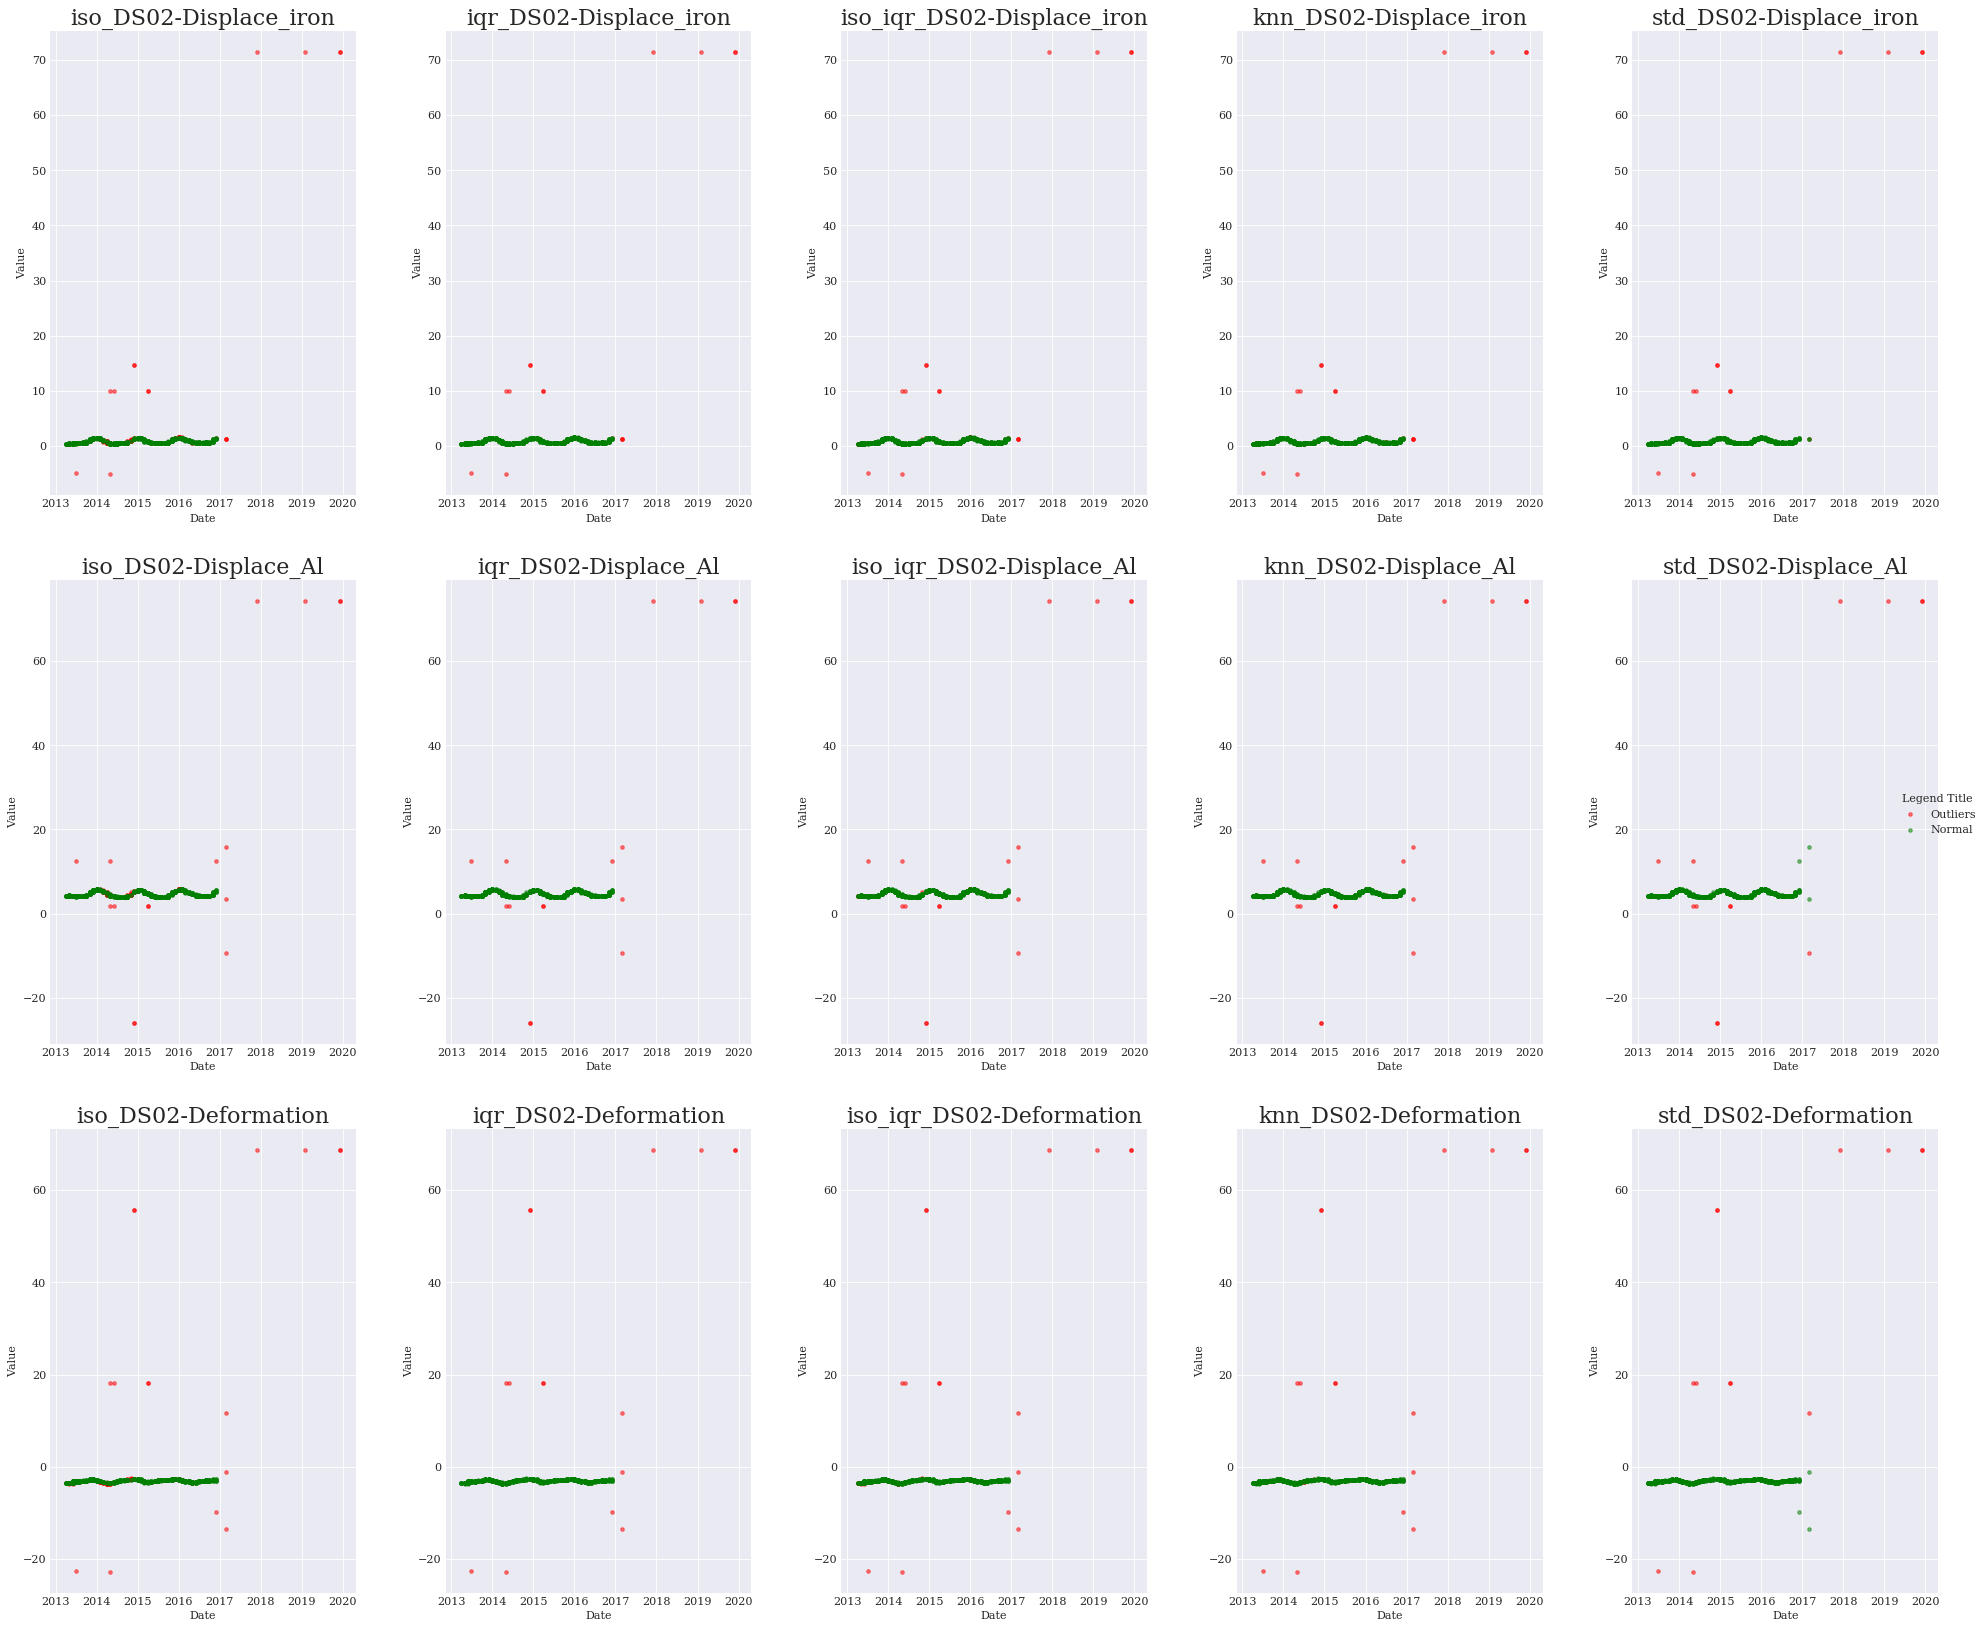

In [12]:
plot_outliers(dict_DS02, 3, 5)

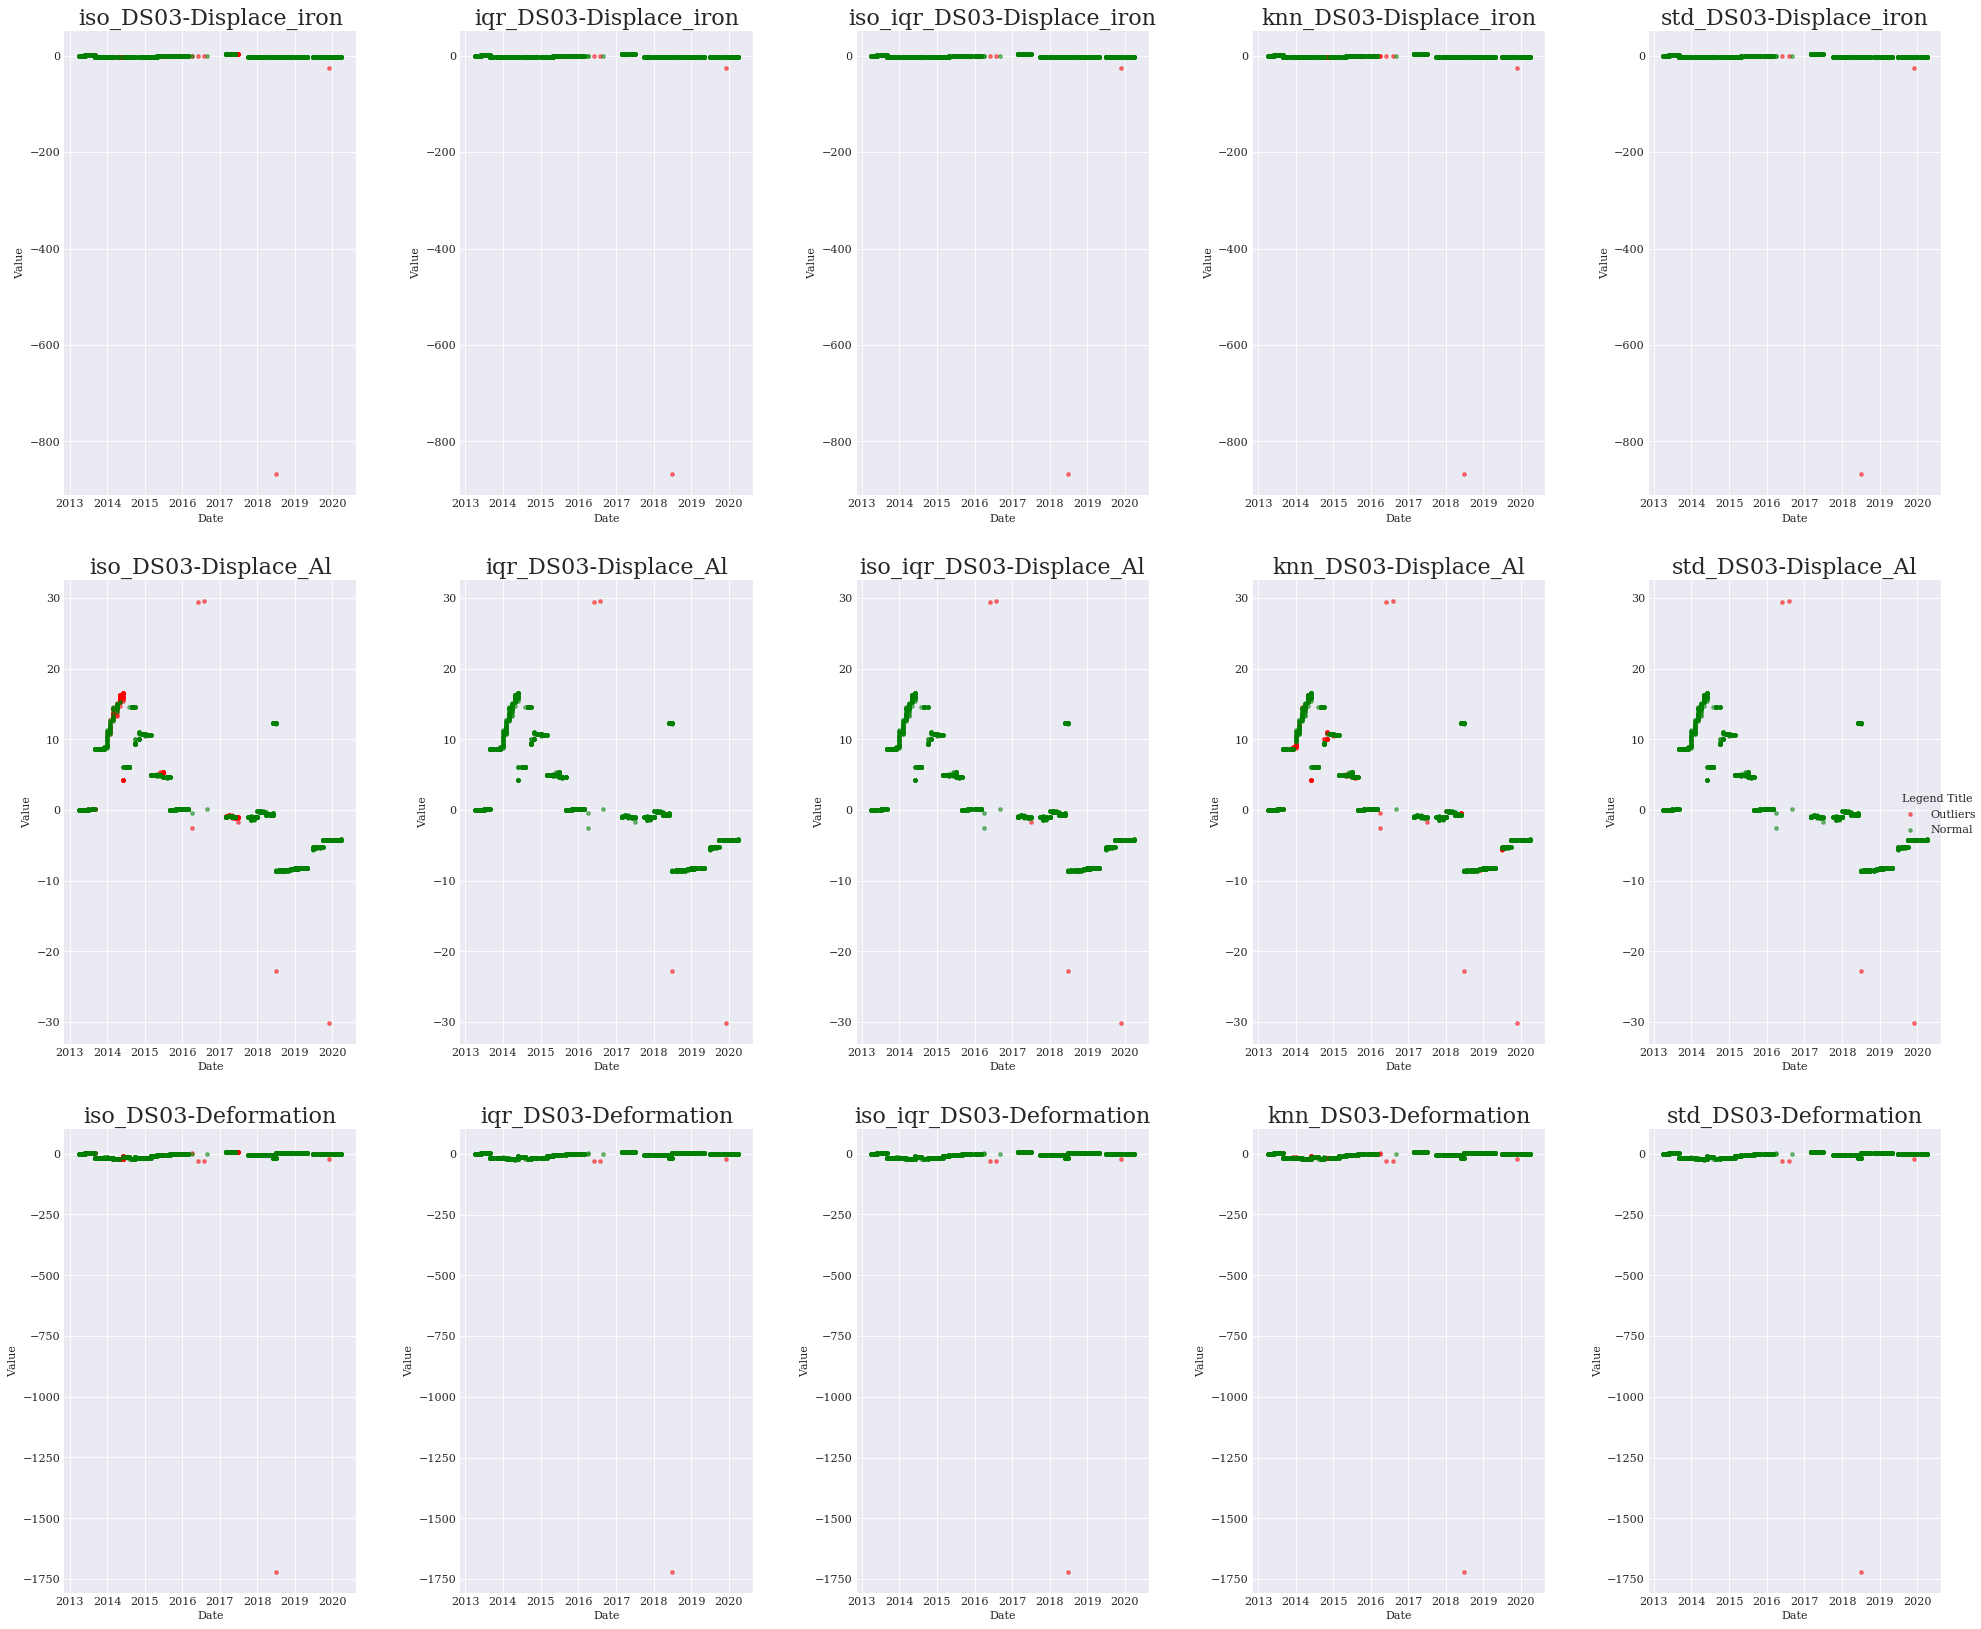

In [13]:
plot_outliers(dict_DS03, 3, 5)

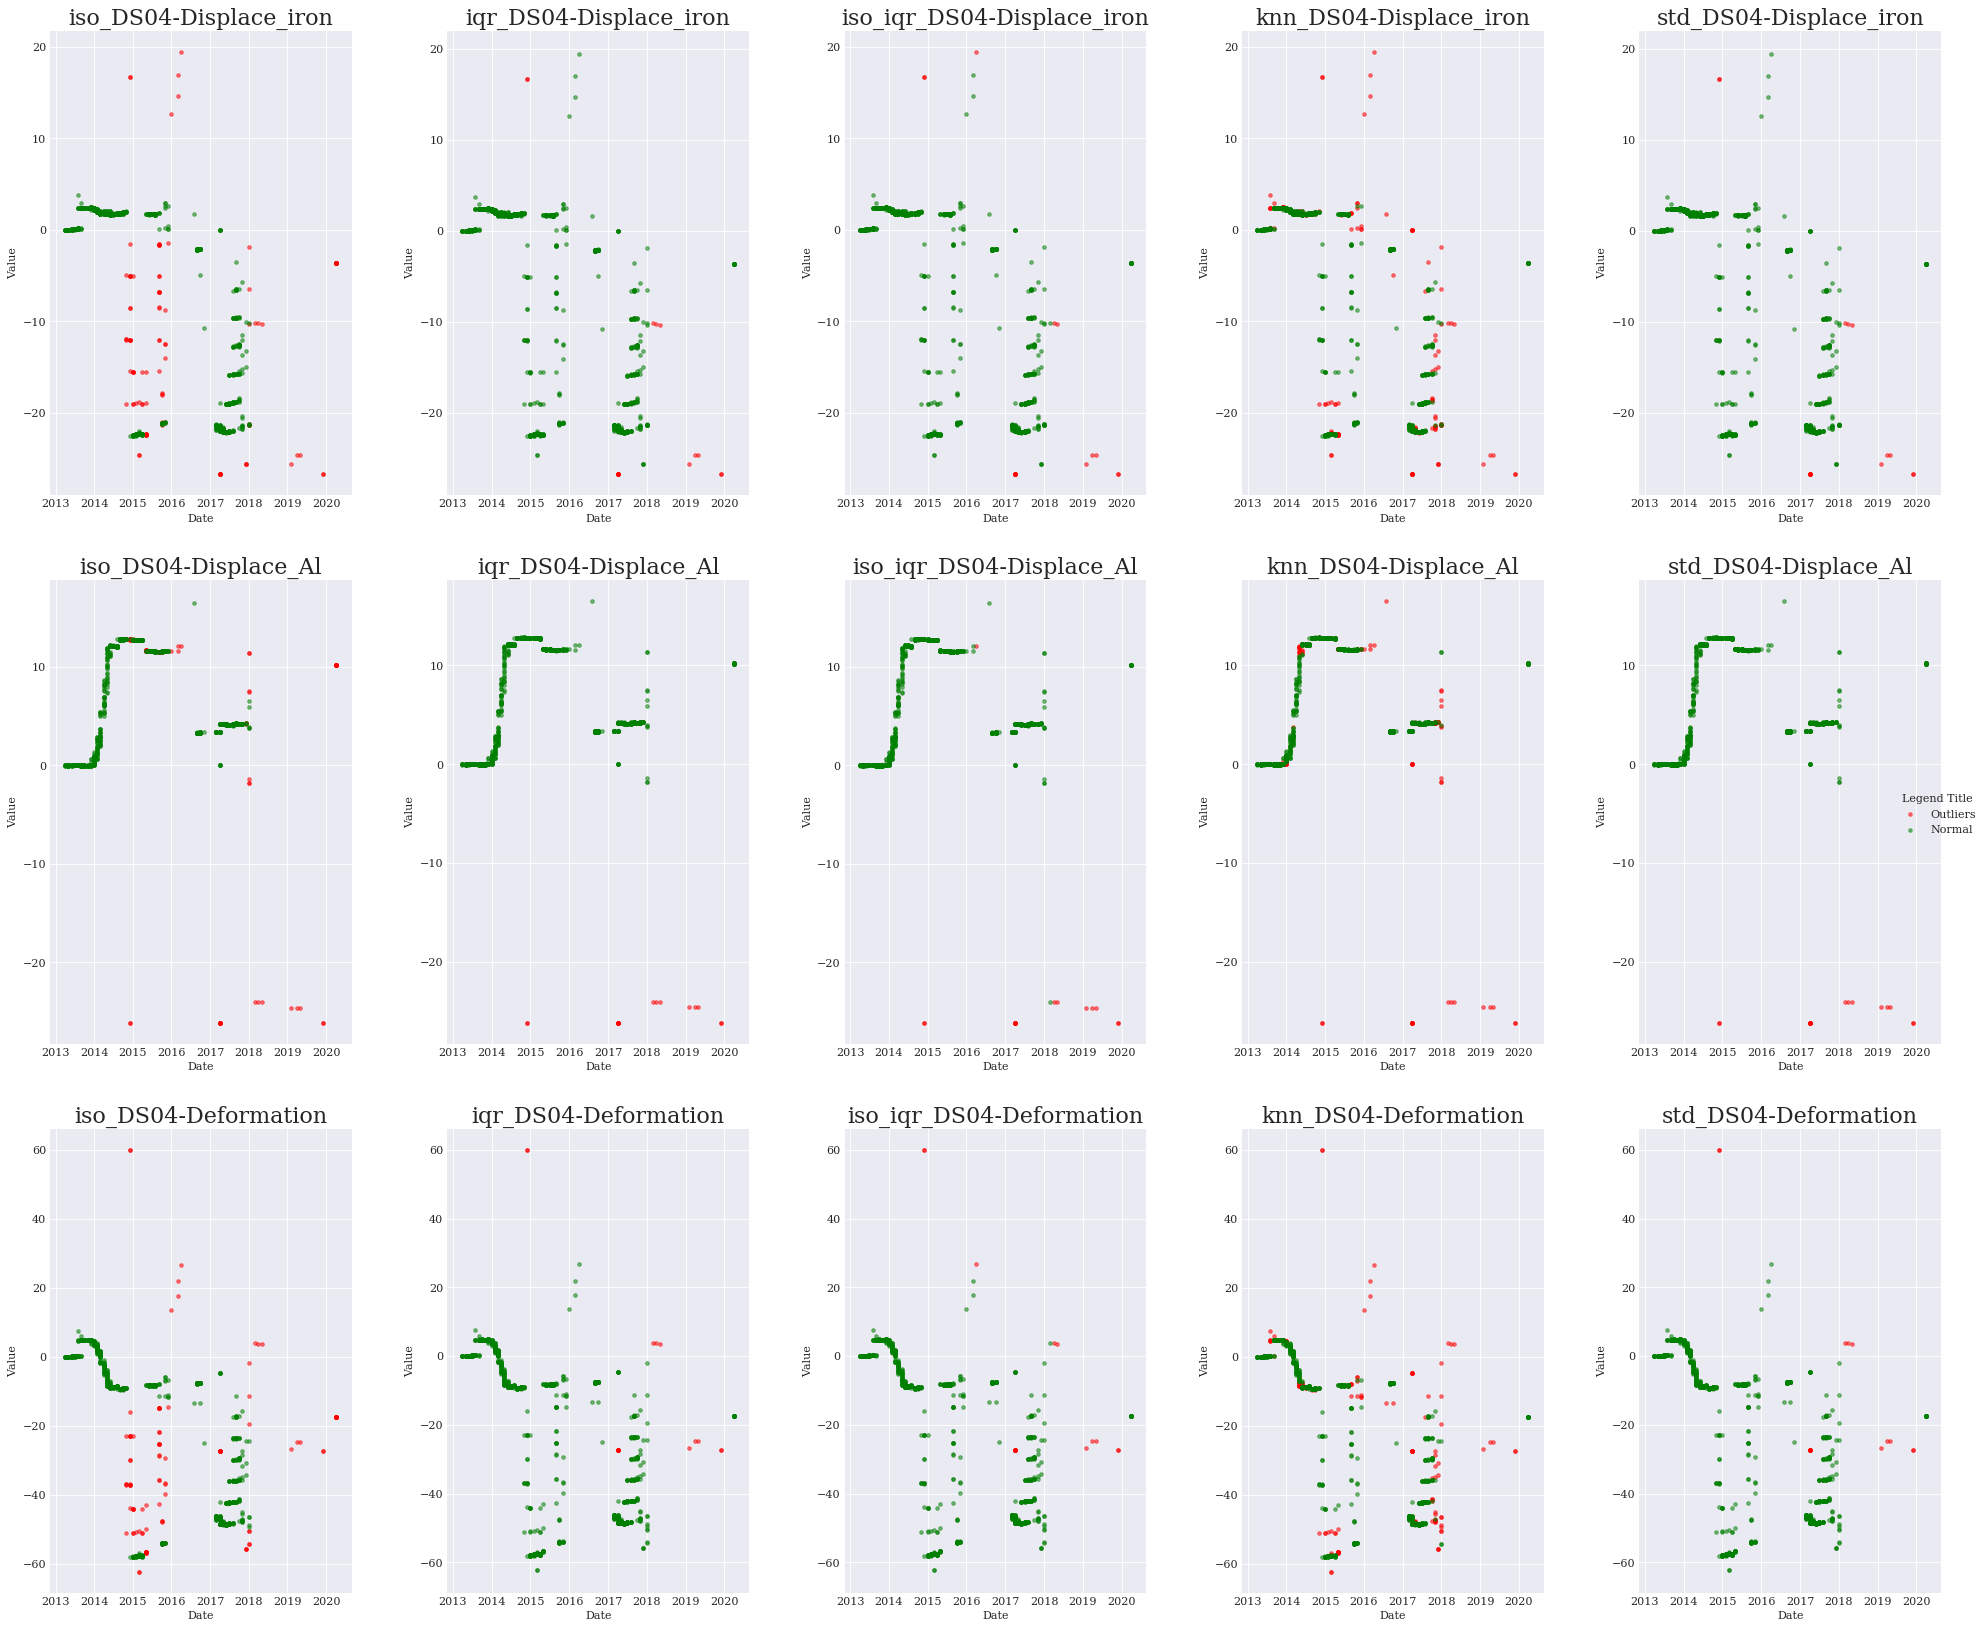

In [14]:
plot_outliers(dict_DS04, 3, 5)

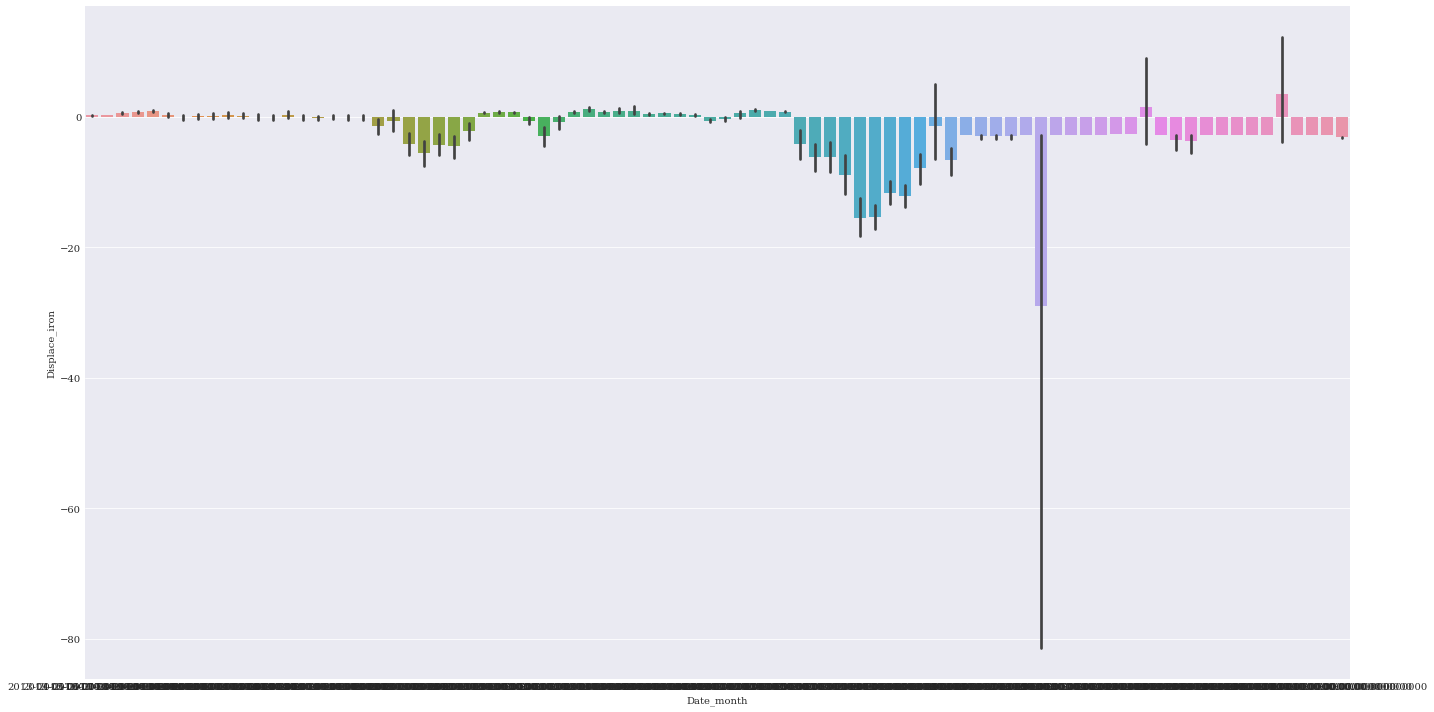

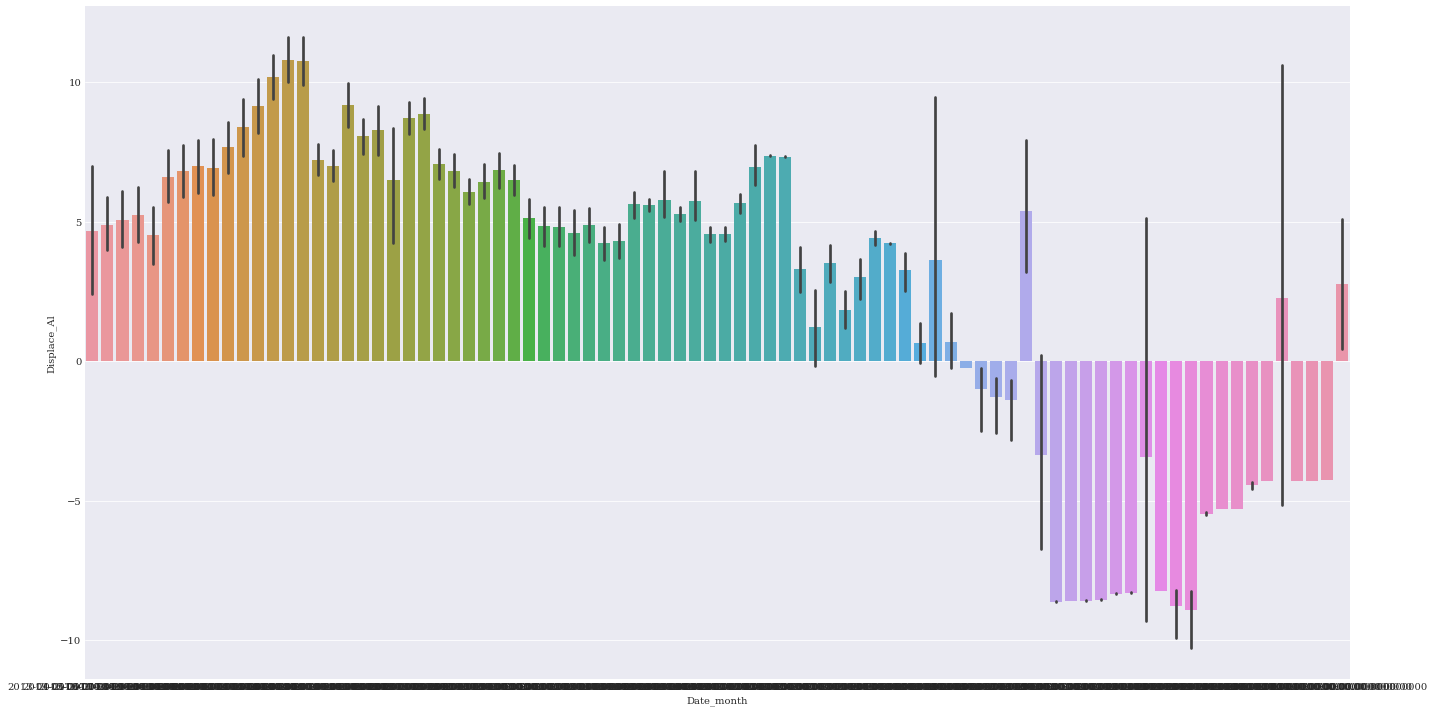

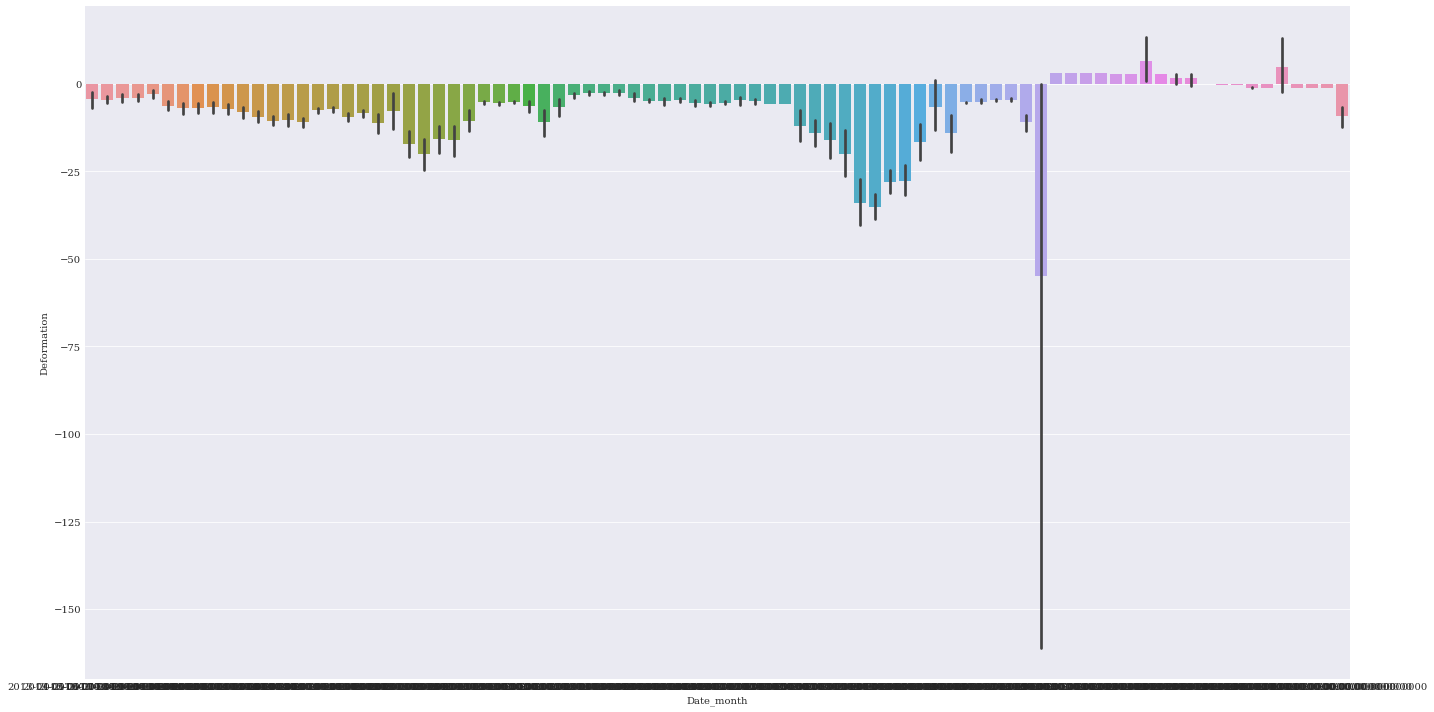

In [15]:
for cat in features:
    sns.catplot(x = 'Date_month', y = cat, data = df, 
                kind = 'bar', height = 10, aspect = 2)